**Executed:** Tue Mar 28 00:43:40 2017

**Duration:** 41 seconds.

In [1]:
measurement_id = 0
windows = (60, 180)

In [2]:
# Cell inserted during automated execution.
windows = (30, 180)
measurement_id = 1

### Notebook arguments

- **measurement_id** (*int*): Select the measurement from the list. Valid values: 0 .. 3

# 1-spot realtime kinetics

<p class=lead>This notebook executes the realtime-kinetics analysis.</p>

The first cell of this notebook selects which measurement is analyzed. 
Measurements can be processed one-by-one, by manually running this notebook,
or in batch by using the notebook: *"1-spot bubble-bubble kinetics - Run-All"*.

## Loading the software

In [3]:
import time
from pathlib import Path
import pandas as pd
from scipy.stats import linregress
from scipy import optimize
from IPython.display import display

In [4]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [5]:
sns = init_notebook(fs=14)

In [6]:
import lmfit; lmfit.__version__

'0.9.5'

In [7]:
import phconvert; phconvert.__version__

'0.7.2'

# Selecting a data file

In [8]:
path = Path('./data/')
pattern = 'singlespot*.hdf5'
filenames = list(str(f) for f in path.glob(pattern))
filenames

['data/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_1.hdf5',
 'data/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2.hdf5',
 'data/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_3.hdf5']

In [9]:
basenames = list(f.stem for f in path.glob(pattern))
basenames

['singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_1',
 'singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2',
 'singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_3']

In [10]:
start_times = [600, 900, 900,
               600, 600, 600, 600, 600, 600, 
               600, 600, 600]  # time of NTP injection and start of kinetics

In [11]:
filename = filenames[measurement_id]
start_time = start_times[measurement_id]

In [12]:
filename

'data/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2.hdf5'

In [13]:
import os
assert os.path.exists(filename)

## Data load and Burst search

Load and process the data:

In [14]:
d = loader.photon_hdf5(filename)

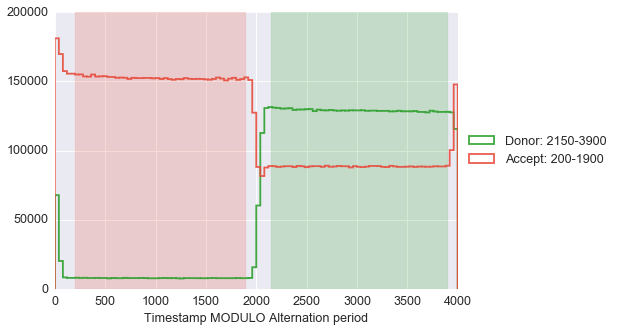

In [15]:
plot_alternation_hist(d)

In [16]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):  16,351,175
#  D  photons in D+A excitation periods:  5,991,074
#  A  photons in D+A excitation periods: 10,360,101
# D+A photons in  D  excitation period:   9,525,878
# D+A photons in  A  excitation period:   6,825,297



In [17]:
d.time_max

4500.0006398999994

Compute background and burst search:

In [18]:
d.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


Let's take a look at the photon waiting times histograms and at the fitted background rates:

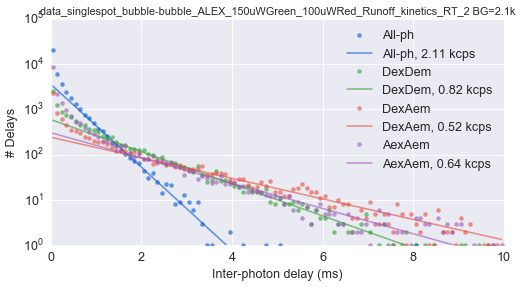

In [19]:
dplot(d, hist_bg);

Using `dplot` exactly in the same way as for the single-spot data has now generated 8 subplots, one for each channel.

Let's plot a timetrace for the background to see is there are significat variations during the measurement:

(750, 1050)

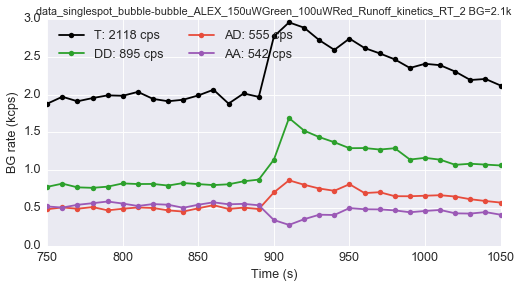

In [20]:
dplot(d, timetrace_bg);
xlim(start_time - 150, start_time + 150)

We can look at the timetrace of the photon stream (binning):

In [21]:
#dplot(d, timetrace)
#xlim(2, 3); ylim(-100, 100);

## Burst selection and FRET

In [22]:
#%%timeit -n1 -r1
ddc = bext.burst_search_and_gate(d)

Deep copy executed.


Deep copy executed.


Deep copy executed.


 - Performing burst search (verbose=False) ...

 - Recomputing background limits for Dex ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Performing burst search (verbose=False) ...

 - Recomputing background limits for AexAem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


In [23]:
ds1 = ddc.select_bursts(select_bursts.size, th1=25)
ds = ds1.select_bursts(select_bursts.naa, th1=25)

### Selecting bursts by size

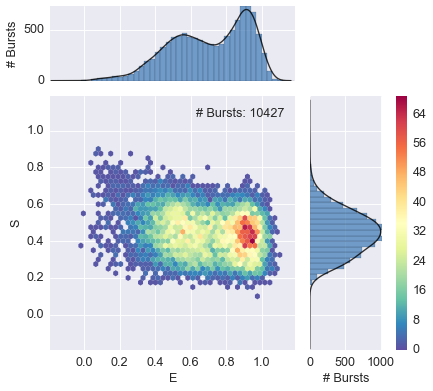

In [24]:
bpl.alex_jointplot(ds)

In [25]:
ds0 = ds.select_bursts(select_bursts.time, time_s1=0, time_s2=start_time-10)

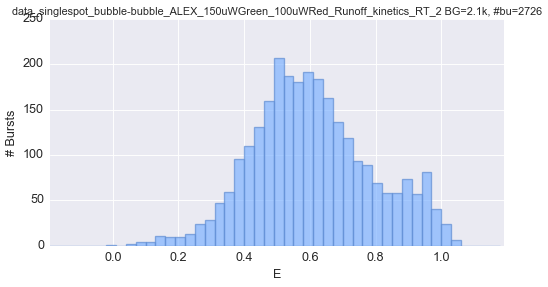

In [26]:
dplot(ds0, hist_fret, pdf=False);

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,0.89677,0.562287,0.138231,0.0936392,0.923001,0.0627824


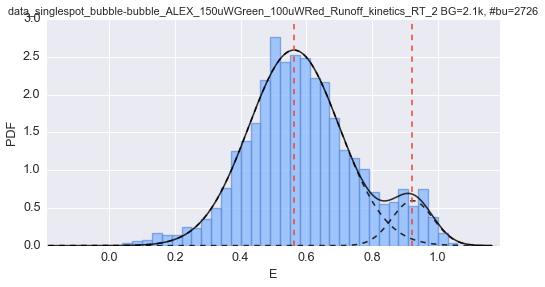

In [27]:
weights = 'size'
bext.bursts_fitter(ds0, weights=weights)
ds0.E_fitter.fit_histogram(mfit.factory_two_gaussians(p1_center=0.5, p2_center=0.9), verbose=False)
dplot(ds0, hist_fret, show_model=True, weights=weights);
ds0.E_fitter.params

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,0.881739,0.56891,0.147244,0.116493,0.928728,0.0620454


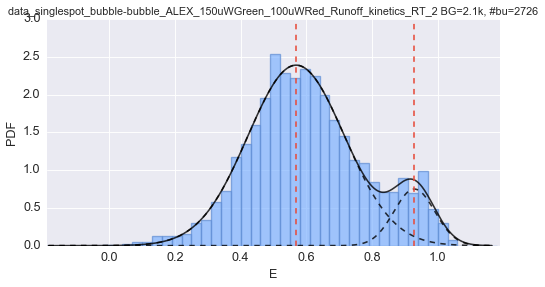

In [28]:
weights = None
bext.bursts_fitter(ds0, weights=weights)
ds0.E_fitter.fit_histogram(mfit.factory_two_gaussians(p1_center=0.5, p2_center=0.9), verbose=False)
dplot(ds0, hist_fret, show_model=True, weights=weights);
ds0.E_fitter.params

## 2-Gaussian peaks

In [29]:
def gauss2(**params0):
    peak1 = lmfit.models.GaussianModel(prefix='p1_')
    peak2 = lmfit.models.GaussianModel(prefix='p2_')
    model = peak1 + peak2
    model.set_param_hint('p1_center', **{'value': 0.6, 'min': 0.3, 'max': 0.8, **params0.get('p1_center', {})})
    model.set_param_hint('p2_center', **{'value': 0.9, 'min': 0.8, 'max': 1.0, **params0.get('p2_center', {})})
    for sigma in ['p%d_sigma' % i for i in (1, 2)]:
        model.set_param_hint(sigma, **{'value': 0.02, 'min': 0.01, **params0.get(sigma, {})})
    for ampl in ['p%d_amplitude' % i for i in (1, 2)]:
        model.set_param_hint(ampl, **{'value': 0.5, 'min': 0.01, **params0.get(ampl, {})})
    model.name = '3 gauss peaks'
    return model

In [30]:
#%matplotlib notebook

In [31]:
#fig, ax = plt.subplots(figsize=(12, 8))
#dplot(dm0, scatter_fret_size, ax=ax)

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,0.881736,0.568909,0.147244,0.116496,0.928726,0.0620476


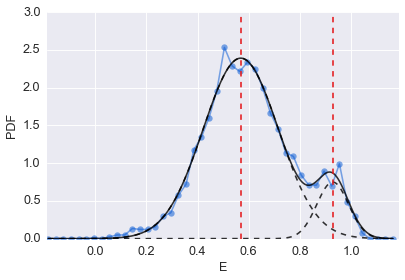

In [32]:
bext.bursts_fitter(ds0, weights=None)
ds0.E_fitter.fit_histogram(gauss2(), verbose=False)
mfit.plot_mfit(ds0.E_fitter)
params_2gauss = ds0.E_fitter.params
plt.xlabel('E')
plt.ylabel('PDF')
plt.title('')
params_2gauss

In [33]:
ds_final = ds.select_bursts(select_bursts.time, time_s1=start_time+300, time_s2=ds.time_max + 1)
ds_final.num_bursts

array([7188])

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,0.604681,0.638728,0.207171,0.414607,0.928726,0.0649994


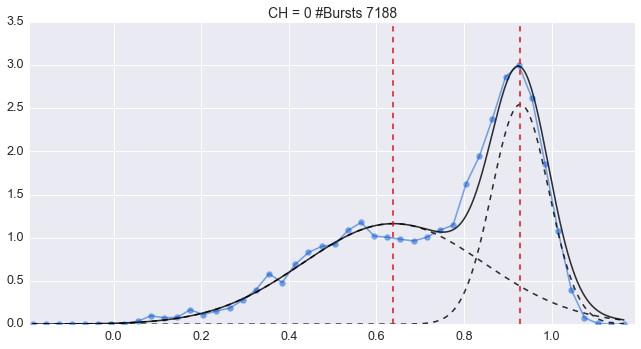

In [34]:
bext.bursts_fitter(ds_final, weights=None)
model = gauss2()
model.set_param_hint('p2_center', value=params_2gauss.p2_center[0], vary=False)
ds_final.E_fitter.fit_histogram(model, verbose=False)
fig, ax = plt.subplots(figsize=(12, 6))
mfit.plot_mfit(ds_final.E_fitter, ax=ax)
params_2gauss1 = ds_final.E_fitter.params
params_2gauss1

In [35]:
#del params_2gauss0

In [36]:
is_runoff = 'runoff' in filename.lower()

In [37]:
if 'params_2gauss0' not in locals():
    params_2gauss0 = params_2gauss.copy()
    if is_runoff:
        params_2gauss0.p2_center = params_2gauss1.p2_center
    else:
        params_2gauss0.p1_center = params_2gauss1.p1_center

In [38]:
params_2gauss0.p1_amplitude + params_2gauss0.p2_amplitude

0    0.998232
dtype: object

In [39]:
'params_2gauss0' in locals()

True

# Fit

In [40]:
from scipy import optimize

In [41]:
params_fixed = dict(
    mu1=float(params_2gauss0.p1_center),
    mu2=float(params_2gauss0.p2_center),
    sig1=float(params_2gauss0.p1_sigma),
    sig2=float(params_2gauss0.p2_sigma),
)

In [42]:
def em_weights_2gauss(x, a2, mu1, mu2, sig1, sig2):
    """Responsibility function for a 2-Gaussian model.
    
    Return 2 arrays of size = x.size: the responsibility of 
    each Gaussian population.
    """
    a1 = 1 - a2
    assert np.abs(a1 + a2 - 1) < 1e-3
    f1 = a1 * gauss_pdf(x, mu1, sig1)
    f2 = a2 * gauss_pdf(x, mu2, sig2)
    γ1 = f1 / (f1 + f2)
    γ2 = f2 / (f1 + f2)
    return γ1, γ2

In [43]:
def em_fit_2gauss(x, a2_0, params_fixed, print_every=10, max_iter=100, rtol=1e-3):
    a2_new = a2_0
    rel_change = 1
    i = 0
    while rel_change > rtol and i < max_iter:

        # E-step
        γ1, γ2 = em_weights_2gauss(x, a2_new, **params_fixed)
        assert np.allclose(γ1.sum() + γ2.sum(), x.size)

        # M-step
        a2_old = a2_new
        a2_new = γ2.sum()/γ2.size

        # Convergence
        rel_change = np.abs((a2_old - a2_new)/a2_new)
        i += 1
        if (i % print_every) == 0:
            print(i, a2_new, rel_change)
        
    return a2_new, i

In [44]:
from matplotlib.pylab import normpdf as gauss_pdf

# Model PDF to be maximized
def model_pdf(x, a2, mu1, mu2, sig1, sig2):
    a1 = 1 - a2
    #assert np.abs(a1 + a2 + a3 - 1) < 1e-3
    return (a1 * gauss_pdf(x, mu1, sig1) + 
            a2 * gauss_pdf(x, mu2, sig2))

def func2min_lmfit(params, x):
    a2 = params['a2'].value
    mu1 = params['mu1'].value
    mu2 = params['mu2'].value
    sig1 = params['sig1'].value
    sig2 = params['sig2'].value
    return -np.sqrt(np.log(model_pdf(x, a2, mu1, mu2, sig1, sig2)))

def func2min_scipy(params_fit, params_fixed, x):
    a2 = params_fit
    mu1 = params_fixed['mu1']
    mu2 = params_fixed['mu2']
    sig1 = params_fixed['sig1']
    sig2 = params_fixed['sig2']
    return -np.log(model_pdf(x, a2, mu1, mu2, sig1, sig2)).sum()

# create a set of Parameters
params = lmfit.Parameters()
params.add('a2', value=0.5, min=0)
for k, v in params_fixed.items():
    params.add(k, value=v, vary=False)

$$f(x) = \frac{A}{\sigma\sqrt{2\pi}}\, e^{-\frac{(x - \mu)^2}{2 \sigma^2}}$$

$$\log f(x) = \log \frac{A}{\sigma\sqrt{2\pi}}\, e^{-\frac{(x - \mu)^2}{2 \sigma^2}} = \log{A} -\log{\sigma} - \log\sqrt{2\pi} -\frac{(x - \mu)^2}{2 \sigma^2}$$

$$w_1 \; f_1(x) + w_2 \; f_2(x) + w_3 \; f_3(x)$$

$$\log (w_1 \; f_1(x)) = \log{w_1} + \log{f_1(x)}$$


In [45]:
x = ds0.E_
#x

#result = lmfit.minimize(func2min_lmfit, params, args=(x,), method='nelder')
#lmfit.report_fit(result.params)

In [46]:
#optimize.brute(func2min_scipy, ranges=((0.01, 0.99), (0.01, 0.99)), Ns=101, args=(params, x))

In [47]:
res_em = em_fit_2gauss(x, 0.5, params_fixed)
res_em

(0.11122191254876375, 7)

In [48]:
res = optimize.minimize(func2min_scipy, x0=[0.5], args=(params_fixed, x), method='Nelder-Mead')
res

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in log


 final_simplex: (array([[ 0.11123047],
       [ 0.11113281]]), array([-856.34947036, -856.34941873]))
           fun: -856.34947036108133
       message: 'Optimization terminated successfully.'
          nfev: 30
           nit: 15
        status: 0
       success: True
             x: array([ 0.11123047])

In [49]:
res = optimize.minimize(func2min_scipy, x0=[0.5], args=(params_fixed, x), bounds=((0,1),), method='SLSQP')
res

     fun: -856.34947553139409
     jac: array([ 0.00520325,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.11120808])

In [50]:
res = optimize.minimize(func2min_scipy, x0=[0.5], args=(params_fixed, x), bounds=((0,1),), method='TNC')
res

     fun: -856.34947552673316
     jac: array([-0.01454055])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 26
     nit: 5
  status: 1
 success: True
       x: array([ 0.11120711])

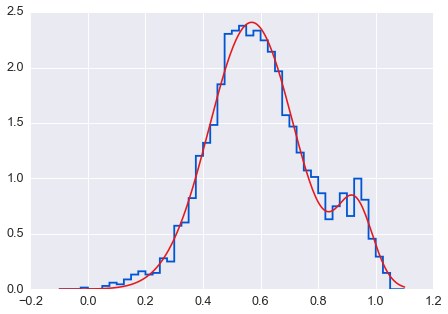

In [51]:
bins = np.arange(-0.1, 1.1, 0.025)
plt.hist(x, bins, histtype='step', lw=2, normed=True);
xx = np.arange(-0.1, 1.1, 0.005)
#plt.plot(xx, model_pdf(xx, params))
plt.plot(xx, model_pdf(xx, a2=res_em[0], **params_fixed))

# Kinetics

## Definitions

In [52]:
def _kinetics_fit_em(dx, a2_0, params_fixed, **kwargs):
    kwargs = {'max_iter': 100, 'print_every': 101, **kwargs}
    a2, i = em_fit_2gauss(dx.E_, a2_0, params_fixed, **kwargs)
    return a2, i < kwargs['max_iter']

def _kinetics_fit_ll(dx, a2_0, params_fixed, **kwargs):
    kwargs = {'method':'Nelder-Mead', **kwargs}
    res = optimize.minimize(func2min_scipy, x0=[a2_0], args=(params_fixed, dx.E_), 
                            **kwargs)
    return res.x[0], res.success
    
def _kinetics_fit_hist(dx, a2_0, params_fixed):
    E_fitter = bext.bursts_fitter(dx)
    model = mfit.factory_two_gaussians()
    model.set_param_hint('p1_center', value=params_fixed['mu1'], vary=False)
    model.set_param_hint('p2_center', value=params_fixed['mu2'], vary=False)
    model.set_param_hint('p1_sigma', value=params_fixed['sig1'], vary=False)
    model.set_param_hint('p2_sigma', value=params_fixed['sig2'], vary=False)
    E_fitter.fit_histogram(model, verbose=False)
    return (float(E_fitter.params.p2_amplitude), 
            dx.E_fitter.fit_res[0].success)

def kinetics_fit(ds_slices, params_fixed, a2_0=0.5, method='em', **method_kws):
    fit_func = {
        'em': _kinetics_fit_em, 
        'll': _kinetics_fit_ll,
        'hist': _kinetics_fit_hist}
    
    fit_list = []
    for dx in ds_slices:
        a2, success = fit_func[method](dx, a2_0, params_fixed, **method_kws)
        df_i = pd.DataFrame(data=dict(p2_amplitude=a2,
                                      p1_center=params_fixed['mu1'], p2_center=params_fixed['mu2'], 
                                      p1_sigma=params_fixed['sig1'], p2_sigma=params_fixed['sig2'],
                                      tstart=dx.slice_tstart, tstop=dx.slice_tstop, 
                                      tmean=0.5*(dx.slice_tstart + dx.slice_tstop)), 
                            index=[0.5*(dx.slice_tstart + dx.slice_tstop)])
        if not success:
            print('* ', end='', flush=True)
            continue
        
        fit_list.append(df_i)
    print(flush=True)
    return pd.concat(fit_list)

In [53]:
start_time/60

15.0

## Moving-window processing

In [54]:
def print_slices(moving_window_params):
    msg = ' - Slicing measurement:'
    for name in ('start', 'stop', 'step', 'window'):
        msg += ' %s = %.1fs' % (name, moving_window_params[name]) 
    print(msg, flush=True)
    num_slices = len(bext.moving_window_startstop(**moving_window_params))
    print('   Number of slices %d' % num_slices, flush=True)

In [55]:
t1 = time.time()
time.ctime()

'Tue Mar 28 00:44:00 2017'

In [56]:
ds.calc_max_rate(m=10)
ds_high = ds.select_bursts(select_bursts.E, E1=0.85)

In [57]:
step = 10
params = {}
for window in windows:
    moving_window_params = dict(start=0, stop=ds.time_max, step=step, window=window)
    print_slices(moving_window_params)

    ds_slices = bext.moving_window_chunks(ds, time_zero=start_time, **moving_window_params)
    for meth in ['em', 'll', 'hist']:
        print('    >>> Fitting method %s ' % meth, end='', flush=True)
        p = kinetics_fit(ds_slices, params_fixed, method=meth)
        print(flush=True)
        p['kinetics'] = p.p2_amplitude
        p = p.round(dict(p1_center=3, p1_sigma=4, p2_amplitude=4, p2_center=3, p2_sigma=4, kinetics=4))
        params[meth, window, step] = p

 - Slicing measurement: start = 0.0s stop = 4500.0s step = 10.0s window = 30.0s


   Number of slices 448


    >>> Fitting method em 

* 

    >>> Fitting method ll 

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in log


    >>> Fitting method hist 

 - Slicing measurement: start = 0.0s stop = 4500.0s step = 10.0s window = 180.0s


   Number of slices 433


    >>> Fitting method em 

    >>> Fitting method ll 

    >>> Fitting method hist 

In [58]:
print('Moving-window processing duration: %d seconds.' % (time.time() - t1))

Moving-window processing duration: 18 seconds.


## Burst-data

In [59]:
#moving_window_params = dict(start=0, stop=dsc.time_max, step=1, window=30)
moving_window_params

{'start': 0, 'step': 10, 'stop': 4500.0006398999994, 'window': 180}

In [60]:
ds_slices_high = bext.moving_window_chunks(ds_high, **moving_window_params)

df = bext.moving_window_dataframe(**moving_window_params) - start_time
df['size_mean'] = [di.nt_.mean() for di in ds_slices]
df['size_max'] = [di.nt_.max() for di in ds_slices]
df['num_bursts'] = [di.num_bursts[0] for di in ds_slices]
df['burst_width'] = [di.mburst_.width.mean()*di.clk_p*1e3 for di in ds_slices]
df['burst_width_high'] = [di.mburst_.width.mean()*di.clk_p*1e3 for di in ds_slices_high]
df['phrate_mean'] = [di.max_rate_.mean() for di in ds_slices]

In [61]:
df = df.round(dict(tmean=1, tstart=1, tstop=1, size_mean=2, size_max=1, 
                   burst_width=2, burst_width_high=2, phrate_mean=1))
df

,tmean,tstart,tstop,size_mean,size_max,num_bursts,burst_width,burst_width_high,phrate_mean
0,-810.0,-900.0,-720.0,144.99,615.3,576,4.00,3.78,225058.7
1,-800.0,-890.0,-710.0,143.86,615.3,560,4.02,3.79,220460.5
2,-790.0,-880.0,-700.0,142.50,615.3,550,4.02,3.71,216329.3
3,-780.0,-870.0,-690.0,143.87,615.3,531,4.07,3.70,215116.5
4,-770.0,-860.0,-680.0,142.38,609.0,526,4.05,3.61,216091.4
...,...,...,...,...,...,...,...,...,...
428,3470.0,3380.0,3560.0,121.12,747.2,430,3.08,2.83,211889.1
429,3480.0,3390.0,3570.0,120.50,747.2,440,3.04,2.82,212818.1
430,3490.0,3400.0,3580.0,120.63,747.2,428,3.03,2.81,214733.4
431,3500.0,3410.0,3590.0,122.90,747.2,421,3.05,2.84,217809.8


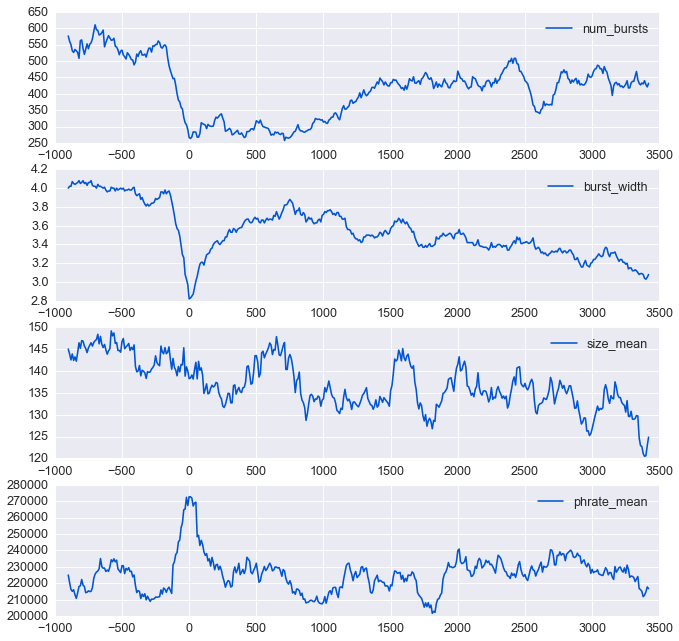

In [62]:
labels = ('num_bursts', 'burst_width', 'size_mean', 'phrate_mean',)
fig, axes = plt.subplots(len(labels), 1, figsize=(12, 3*len(labels)))

for ax, label in zip(axes, labels):
    ax.plot('tstart', label, data=df)
    ax.legend(loc='best')
    #ax.set_ylim(0)

In [63]:
# %%timeit -n1 -r1
# meth = 'em'
# print('    >>> Fitting method %s' % meth, flush=True)
# p = kinetics_fit(ds_slices, params_fixed, method=meth)

In [64]:
# %%timeit -n1 -r1
# meth = 'hist'
# print('    >>> Fitting method %s' % meth, flush=True)
# p = kinetics_fit(ds_slices, params_fixed, method=meth)

In [65]:
# %%timeit -n1 -r1
# meth = 'll'
# print('    >>> Fitting method %s' % meth, flush=True)
# p = kinetics_fit(ds_slices, params_fixed, method=meth)

In [66]:
out_fname = 'results/%s_burst_data_vs_time__window%ds_step%ds.csv' % (
    Path(filename).stem, moving_window_params['window'], moving_window_params['step'])
out_fname

'results/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2_burst_data_vs_time__window180s_step10s.csv'

In [67]:
df.to_csv(out_fname)

## Population fraction

In [68]:
# np.abs((params['em', 30, 1]  - params['ll', 30, 1]).p2_amplitude).max()

In [69]:
methods = ('em', 'll', 'hist')

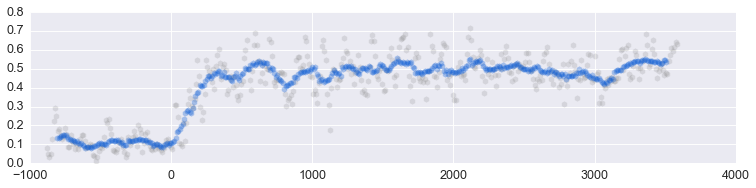

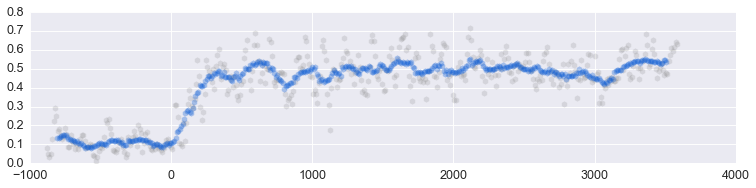

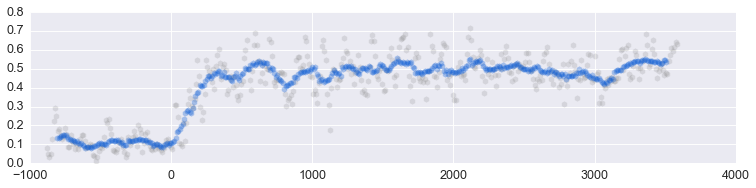

In [70]:
for meth in methods:
    plt.figure(figsize=(14, 3))
    plt.plot(params['em', windows[0], step].index, params['em', windows[0], step].kinetics, 'h', color='gray', alpha=0.2)
    plt.plot(params['em', windows[1], step].index, params['em', windows[1], step].kinetics, 'h', alpha=0.3)

In [71]:
# (params['em', 5, 1].kinetics - params['ll', 5, 1].kinetics).plot()

In [72]:
for window in windows:
    for meth in methods:
        out_fname = ('results/' + Path(filename).stem + 
                     '_%sfit_ampl_only__window%ds_step%ds.csv' % (meth, window, step))
        print('- Saving: ', out_fname)
        params[meth, window, step].to_csv(out_fname)

- Saving:  results/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2_emfit_ampl_only__window30s_step10s.csv
- Saving:  results/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2_llfit_ampl_only__window30s_step10s.csv
- Saving:  results/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2_histfit_ampl_only__window30s_step10s.csv
- Saving:  results/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2_emfit_ampl_only__window180s_step10s.csv
- Saving:  results/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2_llfit_ampl_only__window180s_step10s.csv
- Saving:  results/singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2_histfit_ampl_only__window180s_step10s.csv


In [73]:
d

data_singlespot_bubble-bubble_ALEX_150uWGreen_100uWRed_Runoff_kinetics_RT_2 G1.000 BGexp-10s